In [16]:
from top2vec import Top2Vec
import MeCab
import json
import neologdn
import re
import random
import transformers
import pandas as pd 
transformers.BertTokenizer = transformers.BertJapaneseTokenizer

# df = pd.read_excel('../../public/data/database2020.xlsx')
with open('../../public/data/tdb/BertTopvecHWDSCCCR202101v2.json', 'r')as f:
    df = pd.read_json(f)

In [3]:
def tokenize(text):
    tagger = MeCab.Tagger("mecab -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
    lines = tagger.parse(''.join(text.split())).splitlines()
    words = []
    for line in lines:
        chunk = line.split('\t')
        tmp = chunk[-1].split(',')
        if tmp[0] != 'EOS':
            if tmp[6] != '*':
                words.append(tmp[6])
            else:
                words.append(chunk[0])
    return words

In [17]:
corpus = []
plot_names = []
categories = []
for name, text, category in zip(df['Title'], df['Abstract'], df['Conference']):
    try:
        if text:
            corpus.append((re.sub(r'[0-9]+', "0", neologdn.normalize(text.lower()))))
            # corpus.append(text)
            plot_names.append(name)
            categories.append(category)
            # corpus.append(neologdn.normalize(data[k][2]).lower())
    except:
        print(name, text)

In [11]:
corpus = []
plot_names = []
categories = []
for name, text, category in zip(df['Title'], df['Abstract'], df['Conference']):
    try:
        if text:
            corpus.append((re.sub(r'[0-9]+', "0", neologdn.normalize(text.lower()))))
            # corpus.append(text)
            plot_names.append(name)
            categories.append(category)
            # corpus.append(neologdn.normalize(data[k][2]).lower())
    except:
        print(name, text)

In [18]:
embedding_model="sonoisa/sentence-bert-base-ja-mean-tokens-v2"
model = Top2Vec(corpus, seed=6, tokenizer=tokenize, embedding_model=embedding_model)

2023-03-15 13:07:54,153 - top2vec - INFO - Pre-processing documents for training
2023-03-15 13:08:29,972 - top2vec - INFO - Downloading sonoisa/sentence-bert-base-ja-mean-tokens-v2 model
2023-03-15 13:08:42,374 - top2vec - INFO - Creating joint document/word embedding
2023-03-15 13:28:21,038 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-15 13:28:42,168 - top2vec - INFO - Finding dense areas of documents
2023-03-15 13:28:42,391 - top2vec - INFO - Finding topics


In [37]:
len(model.get_topics()[1])

74

In [24]:
topic_sizes, topic_nums = model.get_topic_sizes()

for i, size in enumerate(topic_sizes):
    print(i, size)

0 1330
1 812
2 503
3 455
4 454
5 347
6 318
7 287
8 254
9 248
10 247
11 241
12 220
13 175
14 152
15 143
16 140
17 139
18 131
19 130
20 129
21 113
22 110
23 107
24 103
25 100
26 99
27 98
28 96
29 96
30 89
31 85
32 83
33 83
34 83
35 82
36 81
37 79
38 78
39 76
40 73
41 73
42 70
43 70
44 69
45 69
46 66
47 66
48 65
49 62
50 62
51 59
52 57
53 56
54 56
55 47
56 45
57 44
58 42
59 40
60 39
61 39
62 38
63 38
64 37
65 37
66 37
67 34
68 33
69 27
70 25
71 23
72 20
73 20


In [39]:
model.save('../../public/data/tdb/models/T2V_CC_230222.model')

In [6]:
model = Top2Vec.load('../../public/data/tdb/models/T2V_CC_230222.model')

In [26]:
phrase = {}
for topic in model.topic_words:
    for word in topic:
        if word not in phrase:
            phrase[word] = 0
        phrase[word] += 1
phrase_sorted = sorted(phrase.items(), key = lambda x:x[1])

tagger = MeCab.Tagger("mecab -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
# NoUseWords = ['業', '費', '品', '社','料','工程','部門','仕入れ','各種','製','店','商', '種', 'メーカー'] #CC
NoUseWords = ['業', '費', '品', '社','料','工程','部門','仕入れ','各種','製','店','商', '種', 'メーカー', '機器'] #HWDSC
exclusion_words = []
for word in phrase_sorted:
    line = tagger.parse(word[0]).split()
    chk = line[1].split(',')
    try:
        # 固有名詞以外外す
        # if line[0][-2:] in exclusion_words or chk[1] != '固有名詞':
        #     NoUseWords.append(line[0])
        # 名詞は全部入れる
        if line[0][-2:] in exclusion_words or chk[0] != '名詞':
            NoUseWords.append(line[0])
        # サ変接続だけ外す
        if line[0][-2:] in exclusion_words or chk[1] == 'サ変接続':
            NoUseWords.append(line[0])
    except:
        NoUseWords.append(line[0])        

import numpy as np
topic = []
for words, scores in zip(model.topic_words, model.topic_word_scores):
    tmp = {}
    for word, score in zip(words, scores):
        tmp[word] = score
    topic.append(tmp)

for words in topic:
    for word in list(words.keys()):
        if word in NoUseWords:
            words.pop(word)

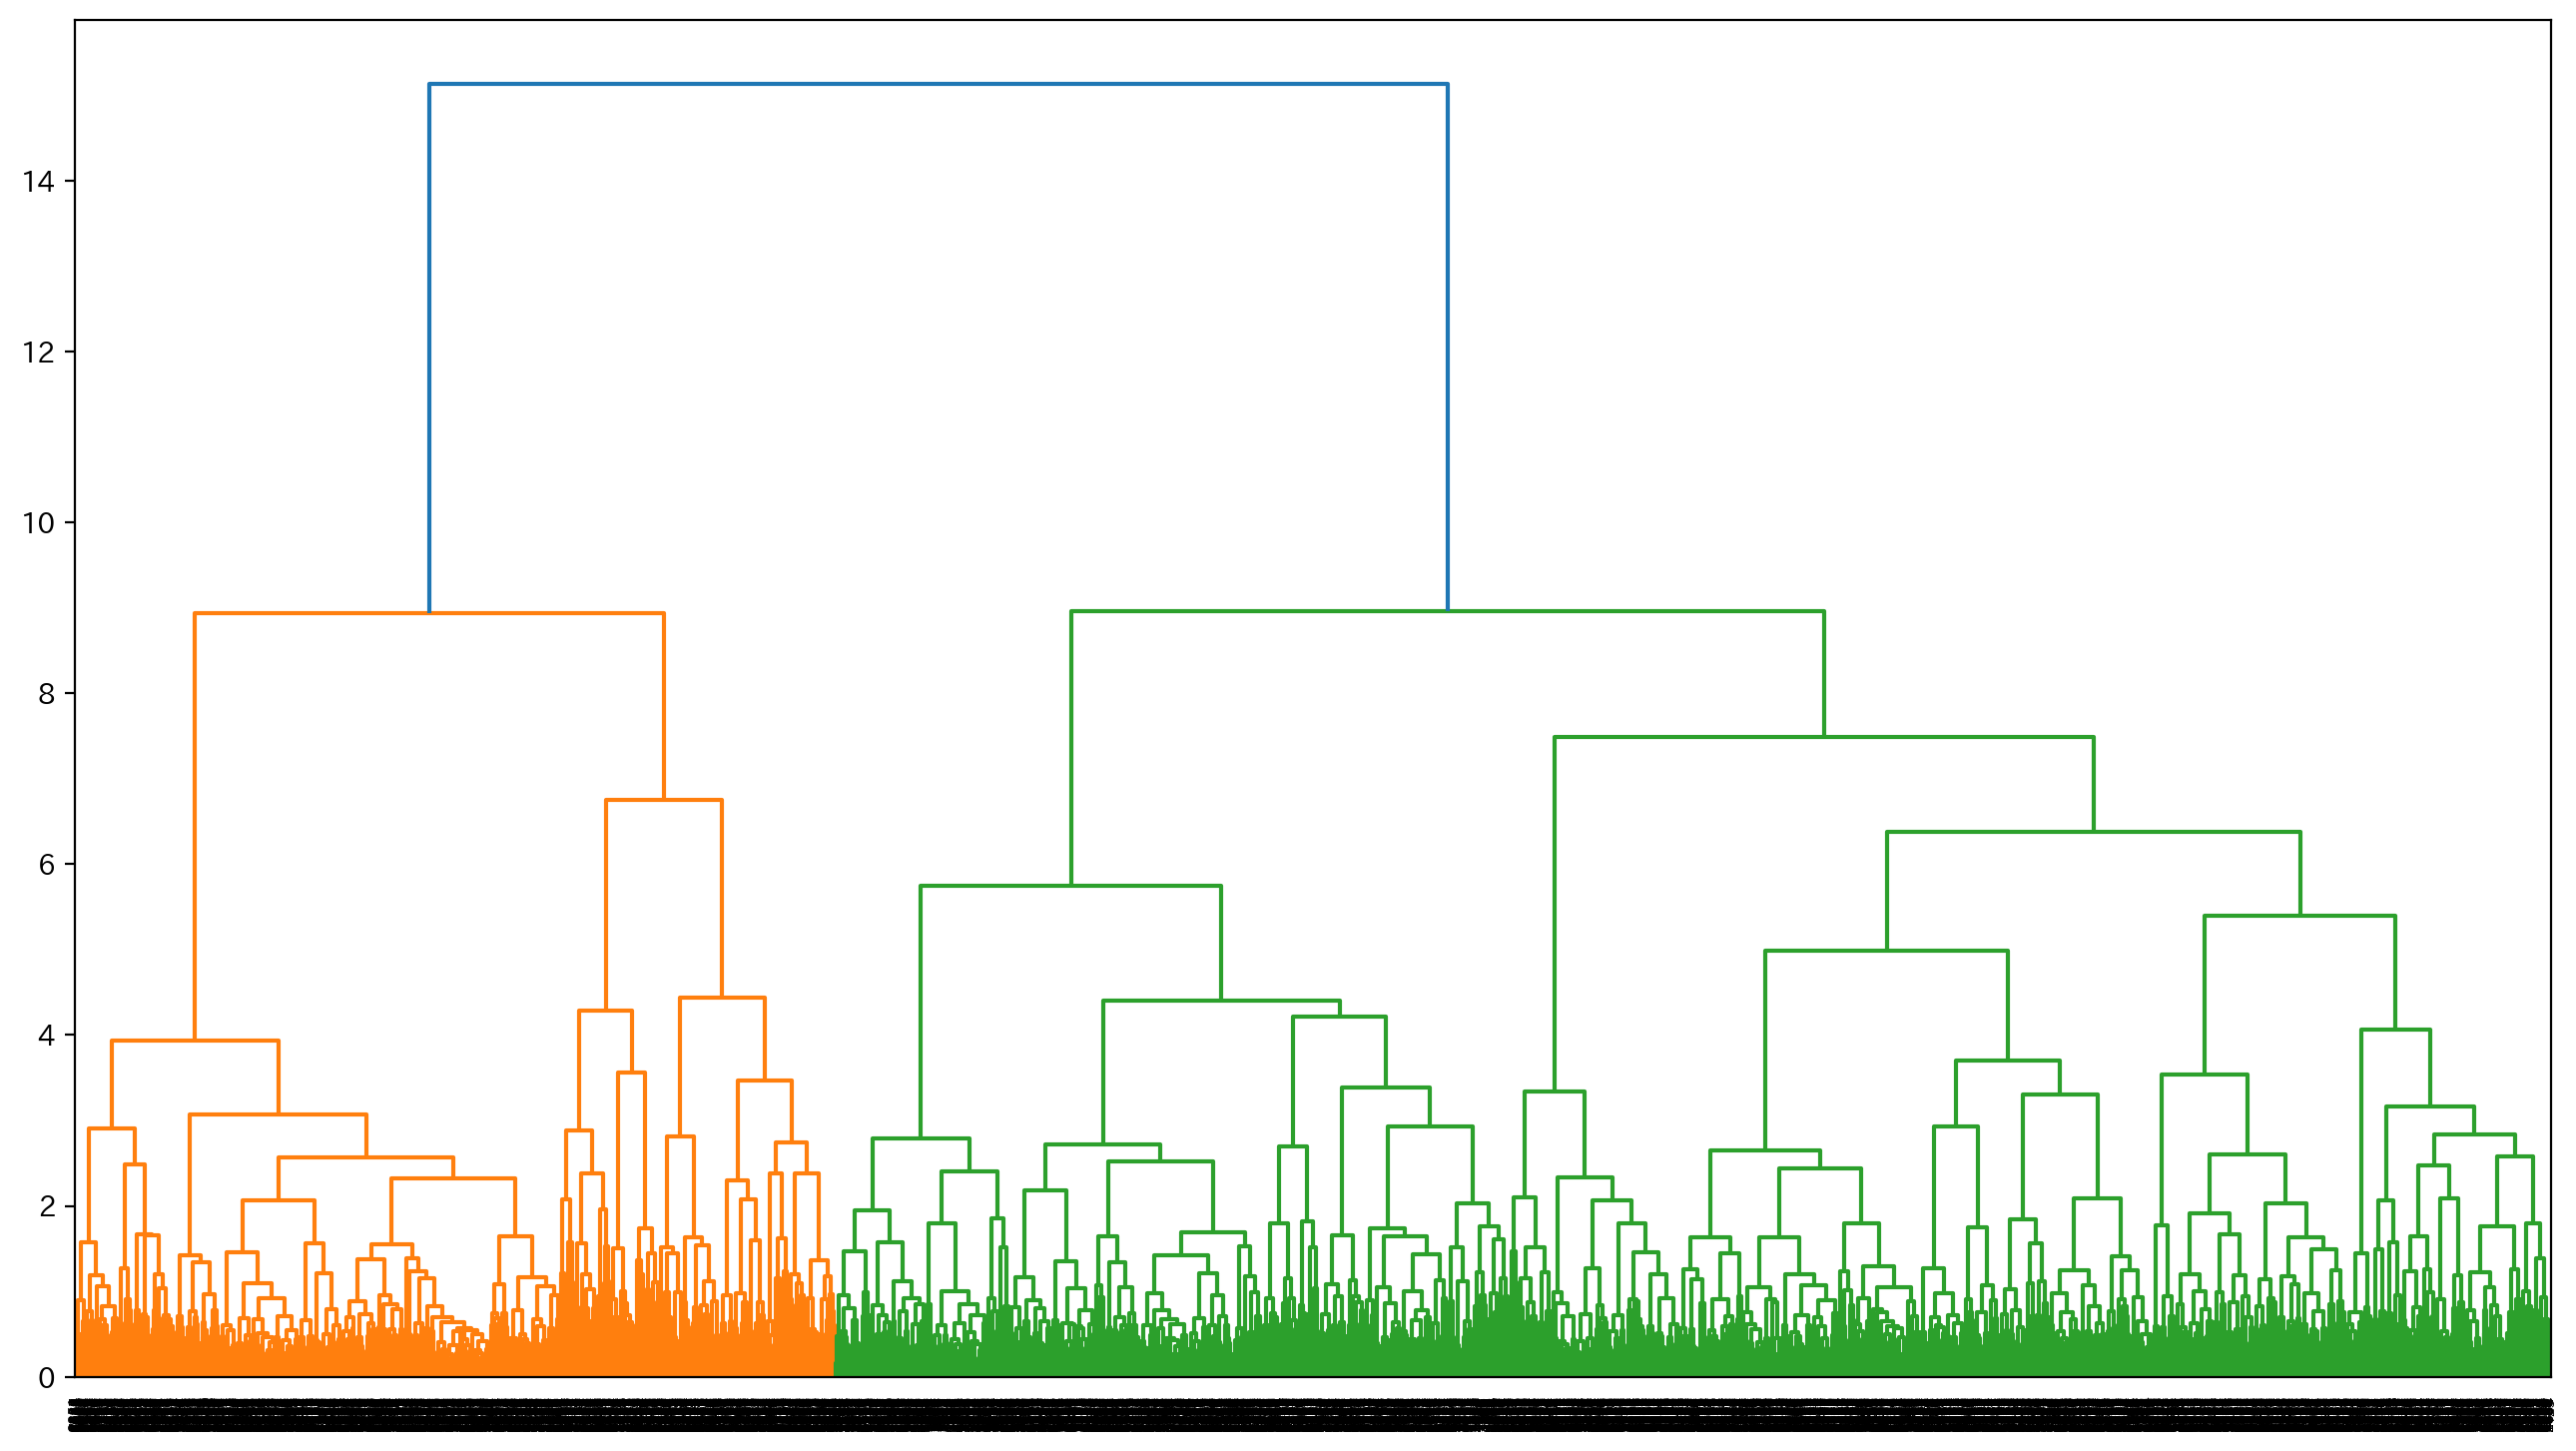

In [20]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
plot_list = model.document_vectors
 
dist = pdist(plot_list, metric='cosine')
linkage_result = linkage(dist, method='ward')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result)
plt.savefig('../../public/data/ss/T2V_CC_230222.png')
plt.show()

In [27]:
obj = []
for i, (title, abstract, conference, text) in enumerate(zip(plot_names, model.documents, categories, df.Abstract)):
  word_score = {}
  topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(doc_ids=[i], num_topics=100)
  for weight, words, scores in zip(topic_score[0], topic_words[0], word_scores[0]):
      # if weight < 0:
      #     continue
      for word, score in zip(words, scores):
        # if word not in NoUseWords and all(NUW not in word for NUW in NoUseWords):
        if all(NUW not in word for NUW in NoUseWords):
          if word not in word_score:
              word_score[word] = 0
          word_score[word] += weight * score

  tmp = sorted([(word, word_score[word]) for word in set(tokenize(model.documents[i])) if word in word_score and word_score[word] > 0], key=lambda item: item[1], reverse=True)

  topvec = []
  for k, v in tmp:
      topvec.append({'word':k,
                      'score':v})

  obj.append({"id":str(i),
              "parent":"",
              "distance":0,
              "name":title,
              "text":text,
              "category":conference,
              "TopicScore":topvec
              })

for i in range(len(linkage_result)):
  obj.append({"id":str(len(corpus)+i),
              "parent":"",
              "distance":linkage_result[i][2],
              "name":"",
              "text":"",
              "category":"",
              "TopicScore":[]
              })

print(len(obj))
for i in range(len(obj)):
  if i % 1000 == 0 :
    print("running", i)
  for j in range(len(linkage_result)):
    if int(obj[i]["id"]) == linkage_result[j][0] or int(obj[i]["id"]) == linkage_result[j][1]:
      obj[i]["parent"] = str(len(linkage_result)+j+1)

15677
running 0
running 1000
running 2000
running 3000
running 4000
running 5000
running 6000
running 7000
running 8000
running 9000
running 10000
running 11000
running 12000
running 13000
running 14000
running 15000


In [32]:
import copy
test = copy.deepcopy(obj)
for t in test:
    t['child'] = [t['id']]
for t in test:
    try:   
        test[int(t['parent'])]['child'].append(t['id'])
    except:
        print(t)
for t in test:
    tmp = []
    for i in range(1, len(t['child'])):
        tmp += test[int(t['child'][i])]['child']
    if tmp != []:
        t['child'] = tmp

{'id': '15676', 'parent': '', 'distance': 15.134251869862451, 'name': '', 'text': '', 'category': '', 'TopicScore': [], 'child': ['15676', '15674', '15675']}


In [33]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
emptyid = []

for i, t in enumerate(test):
    if i % 1000 == 0:
        print(f'did {i}')
    corpus = []
    for c in t['child']:
        s = ''
        for w in test[int(c)]['TopicScore']:
            s += w['word'] + ' '
        corpus.append(s)

    try:
        vectorizer = TfidfVectorizer(tokenizer=tokenize, use_idf=True, smooth_idf=True, sublinear_tf=True)
        X = vectorizer.fit_transform(corpus)
        values = X.toarray()
        feature_names = vectorizer.get_feature_names_out()
        tmp_TfIdf = pd.DataFrame(values, columns = feature_names)

        word_dic = {}
        error_words = []
        for i, c in enumerate(t['child']):
            for w in test[int(c)]['TopicScore']:
                try:
                    if w['word'] not in word_dic:
                        word_dic[w['word']] = 0
                    word_dic[w['word']] += w['score'] * tmp_TfIdf[w['word']][i]
                except:
                    if w['word'] not in error_words:
                        error_words.append(w['word'])
            
        tmp = []
        for k, v in word_dic.items():
            tmp.append({'word':k, 'score':v})
        t['keywords'] = tmp
    except:
        emptyid.append(i)
        t['keywords'] = []
for t in test:
    del t['TopicScore']

did 0
did 1000
did 2000
did 3000
did 4000
did 5000
did 6000
did 7000
did 8000
did 9000
did 10000
did 11000
did 12000
did 13000
did 14000
did 15000


In [35]:
with open('../../public/data/tdb/T2V_HWDSC_230315.json', 'w', encoding='utf8')as f:
    json.dump(test, f, indent=2, ensure_ascii=False)

In [119]:
num_appearance = {}
for n in list(words.values()):
    if len(n) not in num_appearance:
        num_appearance[len(n)] = 0
    num_appearance[len(n)]+=1

In [53]:
sorted_data = {}
for k in sorted(num_appearance.keys()):
    sorted_data[k] = num_appearance[k]

In [54]:
len(words)

1221

In [89]:
sorted_data

{1: 976,
 2: 491,
 3: 288,
 4: 159,
 5: 139,
 6: 107,
 7: 67,
 8: 57,
 9: 46,
 10: 42,
 11: 42,
 12: 18,
 13: 25,
 14: 12,
 15: 18,
 16: 13,
 17: 9,
 18: 9,
 19: 6,
 20: 4,
 21: 4,
 22: 3,
 23: 4,
 24: 2,
 25: 4,
 26: 5,
 27: 2,
 28: 1,
 29: 3,
 30: 1,
 32: 2,
 33: 1,
 34: 1,
 38: 1}

In [56]:
checkid = []
for o in obj:
    checkid.append(o['id'])
checkid2 = set(checkid)

In [57]:
len(checkid) == len(checkid2)

True

In [58]:
checkid2

{'8688',
 '3074',
 '4764',
 '6480',
 '1779',
 '8394',
 '1841',
 '5594',
 '8187',
 '10130',
 '8569',
 '10466',
 '1012',
 '2578',
 '7942',
 '8022',
 '6842',
 '5840',
 '2592',
 '8862',
 '9933',
 '9996',
 '9285',
 '10602',
 '272',
 '4497',
 '415',
 '9036',
 '3202',
 '7924',
 '6640',
 '1253',
 '3033',
 '4802',
 '3143',
 '10108',
 '7384',
 '4474',
 '9348',
 '8920',
 '6616',
 '7408',
 '9794',
 '442',
 '8029',
 '1998',
 '1347',
 '3974',
 '2326',
 '645',
 '184',
 '1103',
 '4972',
 '10557',
 '2447',
 '9037',
 '5746',
 '697',
 '8839',
 '204',
 '2825',
 '648',
 '5622',
 '3356',
 '9609',
 '8328',
 '1093',
 '950',
 '2851',
 '178',
 '4038',
 '1418',
 '10292',
 '5550',
 '3691',
 '5827',
 '6783',
 '3365',
 '871',
 '5327',
 '9563',
 '1002',
 '7299',
 '6972',
 '6350',
 '7115',
 '6655',
 '8842',
 '9278',
 '8904',
 '9870',
 '9291',
 '7775',
 '8404',
 '9415',
 '5067',
 '7163',
 '7285',
 '2186',
 '3160',
 '10408',
 '2290',
 '698',
 '5763',
 '7091',
 '976',
 '1861',
 '2057',
 '2693',
 '3971',
 '5322',
 '5315'